# Load stuff

In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
from scipy.sparse import csr_matrix
import scipy.sparse as sps
import matplotlib.pyplot as plt
!pip install leidenalg # this is the Louvain version we use!!!!
import leidenalg
import igraph as ig
import pickle
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.cm
!pip install umap-learn
import umap
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.8 MB/s eta 0:00:00


In [16]:
!pip install bertopic
from bertopic import BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
class CleanText:
    # in the default mode we leave aside "PRON", they appear too many times
    def __init__(self, text, POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"]):
        # capture execution time
        tic = time.time()
        # store original text
        self.text = list(text)
        # superficially clean it
        sup_clean = [self._superficial_cleaning(i) for i in self.text]
        # store deep cleaning of text
        self.text_clean = [self._deep_cleaning(i,POS_KEEP) for i in sup_clean]
        # store deep cleaning of POS
        self.pos_clean = [self._deep_cleaning_pos(i,POS_KEEP) for i in sup_clean]
        # capture execution time
        print(f'Cleaning text: execution time {time.time()-tic} [s]')

    def _superficial_cleaning(self, selftext):
        # Remove any HTML tag
        soup = BeautifulSoup(selftext, "html.parser")
        outtext = soup.get_text(separator=" ")
        # Remove any text inside square brackets
        outtext = re.sub(r'\[.*?\]', '', outtext)
        # Remove any website links
        outtext = re.sub(r'http\S+', '', outtext)
        outtext = re.sub(r'www.\S+', '', outtext)
        outtext = outtext.replace('. com', '.com')
        # Remove '&amp;#x200B;\n\'
        outtext = re.sub(r'&amp;#x200B;\n\\', ' ', outtext)
        outtext = re.sub(r'‚Äú', ' ', outtext)
        outtext = re.sub(r'‚Äô', "’", outtext)
        # Remove double spaces, newlines, tabs, and combinations
        outtext = re.sub(r' +', ' ', outtext)
        outtext = re.sub(r'\s{2,}', ' ', outtext)
        outtext = re.sub(r'&gt;', ' ', outtext)
        outtext = outtext.replace('-', ' ')
        outtext = outtext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
        # Reduce repetition to two characters for alphabets and to
        # one character for punctuations
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
        outtext = Pattern_alpha.sub(r"\1\1", outtext)
        outtext = Pattern_Punct.sub(r'\1', outtext)
        outtext = re.sub(' {2,}',' ', outtext)
        # Remove extra whitespaces from the text
        pattern = re.compile(r'\s+')
        Without_whitespace = re.sub(pattern, ' ', outtext)
        outtext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return outtext

    def _deep_cleaning(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = ' '.join([token.lemma_ for token in nlp(selftext) if token.pos_ in POS_KEEP])
        return outtext

    def _deep_cleaning_pos(self, selftext,POS_KEEP):
        # Lemmatize + POS using spaCy - works on the polished data
        outtext = [' '.join([token.lemma_,token.pos_]) for token in nlp(selftext) if token.pos_ in POS_KEEP]
        return outtext

In [17]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

def _hlstr(string: str , color: str = 'white'):
    # return f"<mark style=background-color:{color}>{string} </mark>"
    return f"<span style=\"color:{color}\">{string} </span>"

def _colorize(attrs: np.ndarray, cmap: str = 'PiYG'):
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cmap = matplotlib.colormaps.get_cmap(cmap)
    return list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))

def _display_html(tokens, attrs, co=1):
    return HTML("".join(list(map(_hlstr, tokens, _colorize(co*attrs)))))

def get_words_html(vec,wor,N):
    ind = np.argsort(-vec)
    wor = wor[ind[:N]]
    vec = vec[ind[:N]]
    vec = vec/vec[0]
    for j in range(len(wor)):
        wor[j] = str(nlp(str(wor[j]))[0].lemma_)
    return _display_html(wor,vec).data

In [18]:
class TopicDetection:
    ### builds an occurrence matrix for words ###
    def __init__(self, ct_class=[], n_min=2, n_max=1e10):
      if ct_class:
        # capture execution time
        tic = time.time()
        # collection of words
        self.words = np.unique([item for sublist in ct_class.pos_clean for item in sublist])
        # words dictionary
        words_dict = dict(zip(self.words,range(len(self.words))))
        # occurrence matrix for words
        self.Mwd = csr_matrix((len(self.words), len(ct_class.text)), dtype = np.int8).toarray()
        for i in range(len(ct_class.text)):
            for j in ct_class.pos_clean[i]:
                self.Mwd[words_dict[j],i] += 1
        # documents list
        self.documents = np.array(range(len(ct_class.text)))
        # remove words that are used once or twice
        select = ((np.sum(self.Mwd,axis=1)>=n_min)&(np.sum(self.Mwd,axis=1)<n_max))
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(self.words[(np.sum(self.Mwd,axis=1)>=n_max)])
        self.Mwd = self.Mwd[select,:]
        self.words = self.words[select]
        # remove documents that do not contain words
        select = (np.sum(self.Mwd,axis=0)>0)
        self.Mwd = csr_matrix(self.Mwd[:,select])
        self.documents = self.documents[select]
        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

    # plots words occurrencies
    def plot_word_occurrence(self):
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(td1.Mwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies")

    # plots degree distributions
    def plot_degree_distributions(self,quale='words'):
        if quale=='words':
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=1))) # words degrees
        else:
            dw = np.squeeze(np.asarray(self.Mwd.sum(axis=0))) # documents degrees
        # degree distribution
        k = np.unique(dw)
        pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
        pk = pk/pk.sum()
        Pk = 1-np.cumsum(pk)
        # plot
        fig = plt.figure(figsize=(4, 3))
        plt.loglog(k,pk,'o')
        if quale=='words':
            plt.title("degree distribution for words")
        else:
            plt.title("degree distribution for documents")
        plt.xlabel("k")
        plt.ylabel("pk")
        plt.grid(True)
        plt.show()

    # build probability matrices
    def probability_matrices(self, equalik = True, tform = False):
        # capture execution time
        tic = time.time()
        if equalik: # documents equally likely
            self.Pwd = self.Mwd/self.Mwd.sum(axis=0).flatten()/self.Mwd.shape[1]
        else: # documents proportional to their length
            self.Pwd = self.Mwd/self.Mwd.sum()
        # TF-IDF format
        if (tform):
            iw = -logg(np.sum(self.Mwd>0,axis=1).flatten()/self.Mwd.shape[1])
            self.Pwd = sps.diags(np.array(iw)[0]).dot(self.Pwd) # TF-IDF form
            self.Pwd = self.Pwd/self.Pwd.sum() # normalize, treat it as Pwd
        # words and document matrices
        self.pd = self.Pwd.sum(axis=0).flatten()
        self.Pww = (self.Pwd/self.pd).dot(self.Pwd.T)
        self.pw = self.Pwd.sum(axis=1).flatten()
        self.Pdd = (self.Pwd.T/self.pw).dot(self.Pwd)
        # # joint words and document matrix - documents first
        # self.Paa = sps.hstack((sps.csr_matrix((self.Pwd.shape[1],self.Pwd.shape[1])),self.Pwd.T))
        # self.Paa = sps.vstack((self.Paa,sps.hstack((self.Pwd,sps.csr_matrix((self.Pwd.shape[0],self.Pwd.shape[0]))))))
        # self.Paa = self.Paa/2.0
        # ranking vector for Infomap
        self.rd = infomap_rank_fn(self.Pdd)
        # capture execution time
        print(f'Probability matrices: execution time {time.time()-tic} [s]')

    # run topic detection using Louvain
    def topic_detection_louvain(self):
        # capture execution time
        tic = time.time()

        # build a graph based on Pdd as adjacency matrix
        A = sps.csr_matrix(self.Pdd)
        G = ig.Graph.Adjacency((A > 0).toarray().tolist())
        G.es['weight'] = np.array(A[A.nonzero()])[0]
        # run Louvain on the graph to get a partition
        self.topics = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition,
                                        weights='weight')
        # map the partition into a community assignment matrix C
        self.C = self._partition_to_C()
        self.topics = [np.argmax(i) for i in self.C] # turn C into a vector!
        # updates topic matrices
        self.Pwc = self.Pwd.dot(self.C) # joint word + class probability
        self.Pcc = ((self.C.T).dot(self.Pdd)).dot(self.C) # joint class + class probability
        self.pc = self.Pcc.sum(axis=0)

        # capture execution time
        ext = time.time()-tic
        print(f'Louvain topic detection: execution time {ext} [s]')
        return ext

    # function to map the partition into a community assignment matrix C
    # where rows represent documents, and columns represent topics
    def _partition_to_C(self):
      C = sps.csr_matrix((self.Pdd.shape[0],len(self.topics)))
      for i in range(len(self.topics)):
        C[np.array(self.topics[i]),i] = 1
      return C

    # display clustering metrics
    def clustering_metrics(self, ext=np.inf):
        NMI = nmi_fn(self.Pwc)
        Q = modularity_fn(self.Pcc)
        Ncut = ncut_fn(self.Pcc)
        Infomap = infomap_fn(self.C,self.Pdd,self.rd)
        if (self.pc.shape[1]==1):
            com = 0
        else:
            com = _infomap_fn(self.pc)/np.log(self.pc.shape[1])
        if ext==np.inf:
          self.stats = {'topics': self.C.shape[1], 'com': com,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}
        else:
          self.stats = {'topics': self.C.shape[1], 'com': com, 'time': ext,
                        'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}

    # display clusters
    def display_clusters(self):
        # ordered cluster matrix
        pos = np.argsort(np.array([np.argmax(i) for i in self.C]))
        C = sps.csr_matrix(self.C.copy()).astype(np.float32)
        C = C[pos,]
        M = C*(C.T) # binary matrix with ones inside the communities
        # plot
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
        ax[0].plot(np.array(self.C.sum(axis=0))[0]/self.C.sum(),'o')
        ax[0].set_title('clusters dimensions')
        ax[0].grid(True)
        ax[1].imshow(M.toarray(), cmap='viridis')
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].set_title('clusters patterns')

    # display keywords
    def display_keywords(self, text, N=15):
      # build HTML array according to the weights in Pwc
      x = []
      for i in range(self.Pwc.shape[1]):
        x.append([get_words_html(self.Pwc.T[i].toarray()[0],self.words,N)])
      # build HTML array according to TF-IDF weigts in BERTopic
      topic_model = BERTopic() # prepare a BERTopic instance
      topic_model.fit(text)
      topic_model.update_topics(text, topics=self.topics, top_n_words=N)
      bx = [] #
      for k in range(self.C.shape[1]):
        wor = np.array([i for (i,j) in topic_model.get_topic(k)])
        vec = np.array([j for (i,j) in topic_model.get_topic(k)])
        bx.append([get_words_html(vec,wor,N)])
      # join them together and add titles
      c = np.concatenate(([[f'{i}'] for i in range(self.C.shape[1])],
                          [[f'{int(i)}'] for i in np.array(self.C.sum(axis=0))[0]],
                          np.array(x),np.array(bx)), axis=1)
      c = np.concatenate(([['Topic','#docs','Probability matrices keywords',
                                    'BERTopic keywords']],c))
      # map into HTML table and print
      out = '<table><col><col><col width=\"250\"><col width=\"250\">'
      out = out + ''
      for sublist in c:
          out = out + ' <tr><td style=\"padding:1px 8px;\" valign=\"top\">'
          out = out + ' </td><td style=\"padding:1px 8px;\" valign=\"top\">'.join(sublist)
          out = out + ' </td></tr>'
      out = out + ' </table>'
      display(HTML(out))

    # export data
    def pickle_export(self, filename):
        out_data = {
            'words': self.words,
            'documents': self.documents,
            'Mwd': self.Mwd,
            'Pwd': self.Pwd,
            'Pww': self.Pww,
            'Pdd': self.Pdd,
            'pd': self.pd,
            'pw': self.pw,
            'rd': self.rd,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'Pwc': self.Pwc,
            'Pcc': self.Pcc,
            'pc': self.pc,
            'C': self.C,
            'topics': self.topics,
            'stats': self.stats
        }
        with open(filename, 'wb') as f:
            pickle.dump(out_data, f)

    # import data
    def pickle_import(self, filename):
        with open(filename, 'rb') as f:
            in_data = pickle.load(f)
        self.words = in_data['words']
        self.documents = in_data['documents']
        self.Mwd = in_data['Mwd']
        self.Pwd = in_data['Pwd']
        self.Pww = in_data['Pww']
        self.Pdd = in_data['Pdd']
        self.pd = in_data['pd']
        self.pw = in_data['pw']
        self.rd = in_data['rd']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.Pwc = in_data['Pwc']
        self.Pcc = in_data['Pcc']
        self.pc = in_data['pc']
        self.C = in_data['C']
        self.topics = in_data['topics']
        self.stats = in_data['stats']



# Load and clean data

In [4]:
# load dataframe
df = pd.read_csv("climatechange_milton_comments.csv")

# cut df to wanted length
df['create_time'] = pd.to_datetime(df['create_time'])

# Define start and end date
start_date = '2024-09-01'
end_date = '2024-10-01'

# Filter the DataFrame for the date range
df_filtered = df[(df['create_time'] >= start_date) & (df['create_time'] <= end_date)]
df_filtered.sort_index(inplace=True)
df_filtered

,aweme_id,cid,create_time,text,reply_comment_total
13,7420486226056203562,7420575548098118430,2024-09-30,Meanwhile Phoenix AZ had 113 days in a row of ...,113
15,7420486226056203562,7420540250533970730,2024-09-30,It’s not just hurricanes either. I’m in East T...,110
17,7420486226056203562,7420543412976714526,2024-09-30,"Didn’t NC, SC, TN, KY, VA and north GA experie...",102
20,7419367750834851105,7419427958731522848,2024-09-27,¿Por qué nadie les da un tortazo? Soy yo y les...,86
26,7420486226056203562,7420518930924667694,2024-09-30,I'm from Chicago I was shocked to learn we wer...,70
27,7420143167535648046,7420215101430596383,2024-09-29,Why can’t they remember this?,68
33,7419096882678369568,7419324121945228050,2024-09-27,Holy sea and air,60
35,7420486226056203562,7420537966173897503,2024-09-30,"Lake Erie? Like Erie, Pennsylvania???",53
69,7420143167535648046,7420378605567640362,2024-09-30,I live in PR\nno more paper towels\nwe still h...,25
70,7419096882678369568,7420074982199313170,2024-09-29,Holy See and nothing?,25


In [5]:
df_filtered["text"] = df_filtered["text"].astype(str)

<ipython-input-5-6e59bd95a116>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["text"] = df_filtered["text"].astype(str)


In [8]:
df_filtered["text"]

,text
13,Meanwhile Phoenix AZ had 113 days in a row of ...
15,It’s not just hurricanes either. I’m in East T...
17,"Didn’t NC, SC, TN, KY, VA and north GA experie..."
20,¿Por qué nadie les da un tortazo? Soy yo y les...
26,I'm from Chicago I was shocked to learn we wer...
27,Why can’t they remember this?
33,Holy sea and air
35,"Lake Erie? Like Erie, Pennsylvania???"
69,I live in PR\nno more paper towels\nwe still h...
70,Holy See and nothing?


In [7]:
!pip install deep_translator
!pip install langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=cae61928fe1dc5c48d2599cf72d020046e8e458d563fe7df0a3c4e26eca5b3c9
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [9]:
from deep_translator import GoogleTranslator
from langdetect import detect

def translate_non_english(comments):
    translator = GoogleTranslator(source='auto', target='en')
    translated_comments = []

    for comment in comments:
        try:
            lang = detect(comment)  # Detect the language
            if lang != 'en':
                translated_comment = translator.translate(comment)
                translated_comments.append(translated_comment)
            else:
                translated_comments.append(comment)
        except Exception as e:
            translated_comments.append(comment)  # If detection fails, keep the original text

    return translated_comments

# Example usage:
translated_comments = translate_non_english(df_filtered["text"])
print(translated_comments)


['Meanwhile Phoenix AZ had 113 days in a row of 100+ weather and we will be over 100 for the next few weeks summers are becoming more unbearable. Global warming is real and something needs to be done.', 'It’s not just hurricanes either. I’m in East Texas and our spring showers have become annual tornadic supercells. If there’s thunder there’s a tornado. It’s scary!', 'Didn’t NC, SC, TN, KY, VA and north GA experience historic rain from a different system just prior to Helene that had already saturated the land leaving the rain from Helene no where else to go', 'Why does nobody give them a tortazo? It is me and they lack field to run.', "I'm from Chicago I was shocked to learn we were getting 30mph gusts of wind from Helene when most of the storm was still NC. This is our future now.", 'Why can’t they remember this?', 'Holy sea and air', 'Lake Erie? Like Erie, Pennsylvania???', 'I live in PR\nno more paper towels\nwe still have homes with tarps for roofs', 'Holy See and nothing?', "My t

In [14]:
# initialise the class with the textual data, and polish it: no "PRON", too many
# 44 sec for 3k sentences
ct1 = CleanText(translated_comments, POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB"])

Cleaning text: execution time 0.7072324752807617 [s]


In [12]:
translated_comments

['Meanwhile Phoenix AZ had 113 days in a row of 100+ weather and we will be over 100 for the next few weeks summers are becoming more unbearable. Global warming is real and something needs to be done.',
 'It’s not just hurricanes either. I’m in East Texas and our spring showers have become annual tornadic supercells. If there’s thunder there’s a tornado. It’s scary!',
 'Didn’t NC, SC, TN, KY, VA and north GA experience historic rain from a different system just prior to Helene that had already saturated the land leaving the rain from Helene no where else to go',
 'Why does nobody give them a tortazo? It is me and they lack field to run.',
 "I'm from Chicago I was shocked to learn we were getting 30mph gusts of wind from Helene when most of the storm was still NC. This is our future now.",
 'Why can’t they remember this?',
 'Holy sea and air',
 'Lake Erie? Like Erie, Pennsylvania???',
 'I live in PR\nno more paper towels\nwe still have homes with tarps for roofs',
 'Holy See and nothing

In [ ]:
comments = ct1.text_clean
comments

['meanwhile Phoenix AZ have day row weather next few week summer become more unbearable global warming real need do',
 '’ just hurricane either ’m East Texas spring shower become annual tornadic supercell ’ thunder ’ tornado ’ scary',
 'NC SC TN KY VA north GA experience historic rain different system just prior Helene already saturate land leave rain Helene else go',
 'Por qué nadie da un tortazo Soy yo y les falta campo para correr',
 'Chicago shocked learn get mph gust wind Helene most storm still NC future now',
 'remember',
 'Holy sea air',
 'Lake Erie Erie Pennsylvania',
 'live pr more paper towel still have home tarp roof',
 'Holy See',
 'thing initially want accept pr apart US',
 'Holy Sea great country world',
 'Vatican City holy see other country air',
 'tengo una pregunta y esto que ayuda al medio ambiente que tiene que ver el arte con el cambio climático perdí algo',
 'Holy sea',
 '’ so much ppl need remember',
 'spend month electricity month whater cellphone signal almost 

In [ ]:
# save to csv
pd.DataFrame(translated_comments).to_csv("BeforeMilton.csv")

removing words...
[]
Occurrence matrix: execution time 0.009305238723754883 [s]
Probability matrices: execution time 0.0356748104095459 [s]


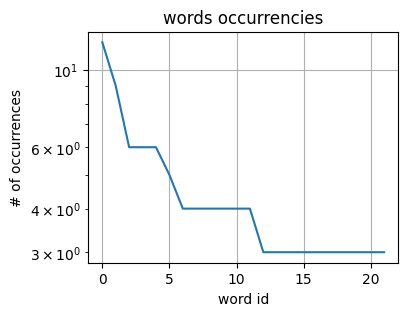

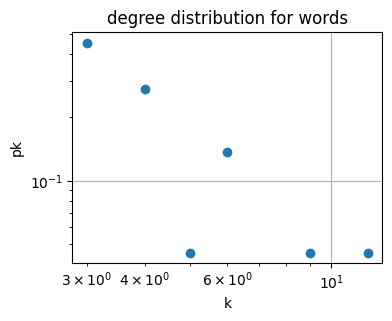

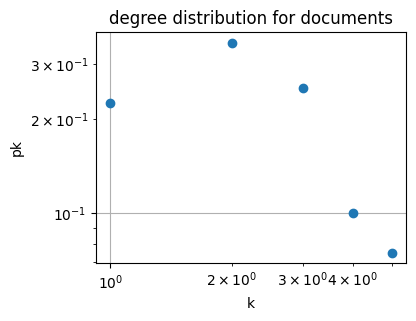

In [19]:
# initialize the class
# use min and max to control which words you are using
td1 = TopicDetection(ct1, n_min=3, n_max=100) # <-- min and max here!
# and build probability matrices first
td1.probability_matrices()
# show words occurrences
td1.plot_word_occurrence()
# show words degree distribution
td1.plot_degree_distributions(quale='words')
# show documents degree distribution
td1.plot_degree_distributions(quale='documents')

Louvain topic detection: execution time 0.031889915466308594 [s]


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


{'topics': 8,
 'com': 0.918599340678336,
 'time': 0.031889915466308594,
 'NMI': 0.7969750426269006,
 'Q': 0.6049698424533386,
 'Ncut': 0.25198617305935506,
 'Infomap': -0.15639606371274206}

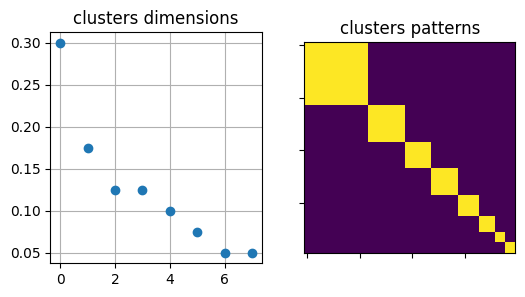

In [20]:
# run louvain clustering - it takes 16 sec for 3K documents
ext = td1.topic_detection_louvain()
# evaluate clustering metrics
td1.clustering_metrics(ext)
# show clusters sizes
td1.display_clusters()
# show statistics
td1.stats

In [21]:
# save topic assignment
df['topic'] = np.nan
topics = np.array(df['topic'])
topics[td1.documents] = td1.topics # not all the documents are assigned to topics!
df['topic'] = topics
df.to_excel("Ian_comments_topics.xlsx")

In [22]:
# save class
td1.pickle_export("Ian_comments.pickle")

In [23]:
# load data
td2 = TopicDetection()
td2.pickle_import("Ian_comments.pickle")

In [24]:
# display keywords from Pwc and BERTopic
active_docs = [ct1.text[i] for i in td2.documents] # not all asiigned to topics
td2.display_keywords(active_docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-02-07 18:42:04,902 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic,#docs,Probability matrices keywords,BERTopic keywords
0,12,have do thing want pr just need book help water sea say pray Helene now,have do that to thing they of what with want do the and not we
1,7,go now Helene book year have say just water want thing sea pray need one,from to helene now go the be never use nc when rain old every year
2,5,sea Holy year Helene water want thing say pray pr one need month just help,sea holy nothing and be mean holly increase you true whoever believe air see must
3,5,country pray Holy have help Helene water want thing sea say pr need now year,all the country for holy and in bad world ground 24hrs clear jerr boot country
4,4,' one need just country water want thing sea say pray pr Holy now year,one be there who hand its clean need no the that with and in spring
5,3,help need say do water want thing sea pray pr one Helene year month just,be to and add stock animal after cause alphabet line definitely crop helpedprofit state then
6,2,just month pr Helene water want thing sea say pray one need year help have,month without just in toss spend whater almost meet bro joke signal google electricity conference
7,2,water do need want thing sea say pray pr one now Helene month just help,water flow its quality waste time surely start stagnant should river river rise let good
